In [5]:
%matplotlib inline
from scipy import *
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy import constants as ac
import exoplanet as xo
import celerite
import lightkurve as lk
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
import pymc3 as pm

In [9]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

In [6]:
lcfs = lk.search_lightcurvefile("TIC 273589987")
lcfs

#,observation,target_name,productFilename,distance
0,Kepler Quarter 0,kplr009726699,kplr009726699-2009131105131_llc.fits,0.0
1,Kepler Quarter 1,kplr009726699,kplr009726699-2009166043257_llc.fits,0.0
2,Kepler Quarter 2,kplr009726699,kplr009726699-2009259160929_llc.fits,0.0
3,Kepler Quarter 3,kplr009726699,kplr009726699-2009350155506_llc.fits,0.0
4,Kepler Quarter 4,kplr009726699,kplr009726699-2010078095331_llc.fits,0.0
5,Kepler Quarter 5,kplr009726699,kplr009726699-2010174085026_llc.fits,0.0
6,Kepler Quarter 6,kplr009726699,kplr009726699-2010265121752_llc.fits,0.0
7,Kepler Quarter 8,kplr009726699,kplr009726699-2011073133259_llc.fits,0.0
8,Kepler Quarter 9,kplr009726699,kplr009726699-2011177032512_llc.fits,0.0
9,Kepler Quarter 10,kplr009726699,kplr009726699-2011271113734_llc.fits,0.0


In [7]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans().remove_outliers()
    except:
            print(q)

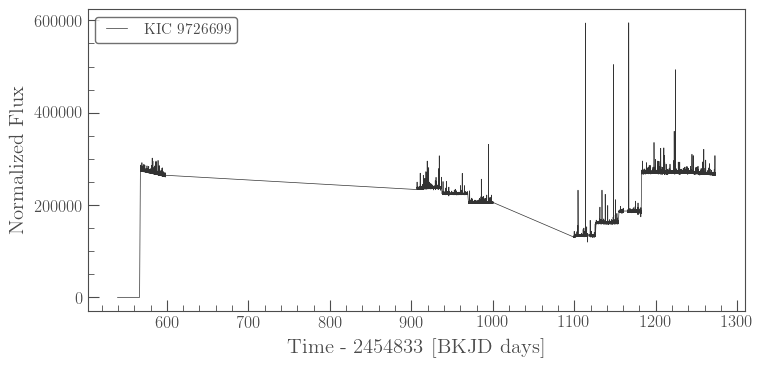

In [10]:
gj1243lc.plot();

In [12]:
_, mask = gj1243lc.flatten().remove_outliers(sigma=3.0, return_mask=True)

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

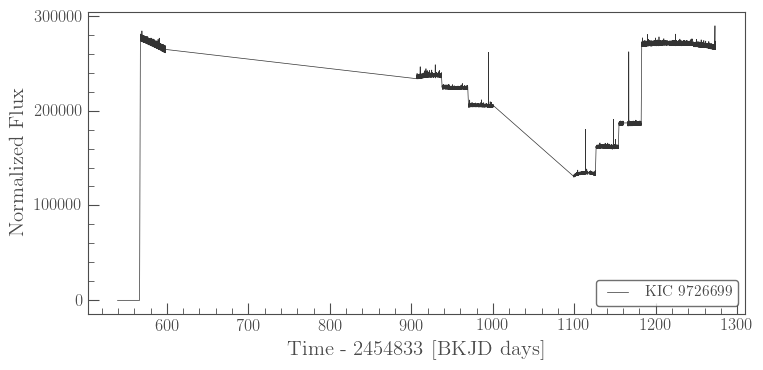

In [13]:
gj1243lc[~mask].plot()

### Masking out the flares


In [15]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

In [16]:
f_mask = np.zeros_like(gj1243lc.time, dtype=bool)
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5  
    buffer = (gj1243lc.time >= t_starts[i] - c1*dur) & (gj1243lc.time <= t_stops[i] + c2*dur)
    temp = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)
no_flares = np.where((f_mask == False))[0]

[False False False ... False False False]


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

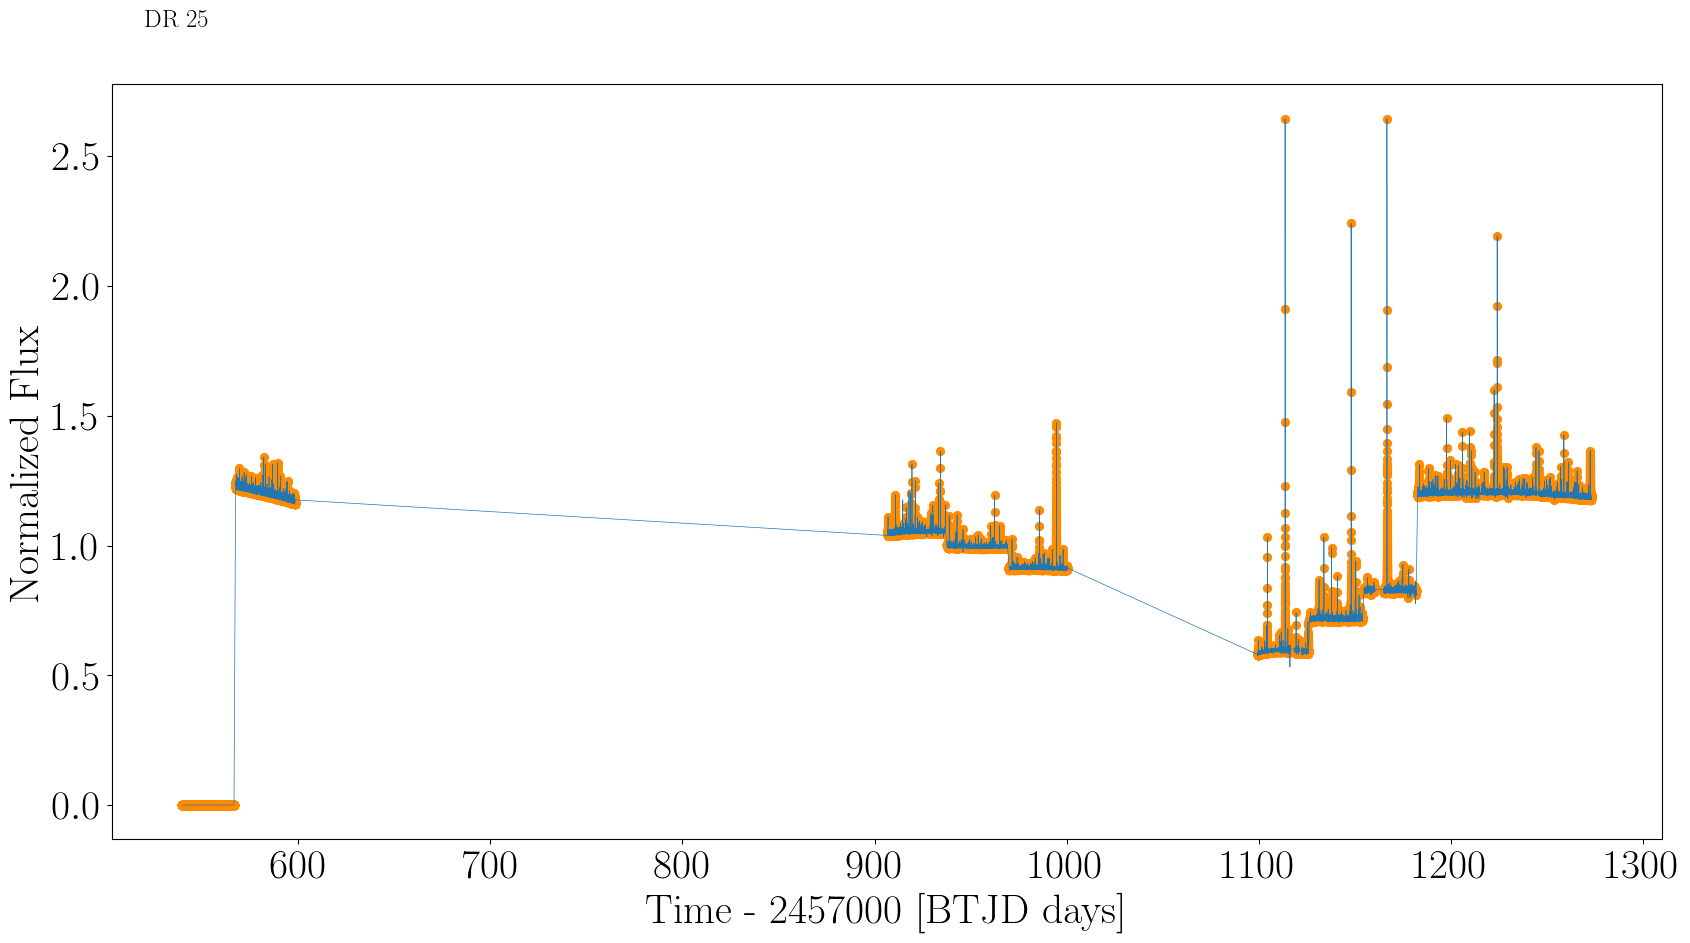

In [17]:
flares_x=gj1243lc.time[f_mask]
flares_y = gj1243lc.flux[f_mask]/np.nanmedian(gj1243lc.flux)

fig = plt.figure(figsize=(20,10))
import matplotlib
matplotlib.rcParams.update({'font.size':30})
matplotlib.rcParams.update({'font.family':'serif'})

fig.subplots_adjust(hspace=0.3, wspace=0.4)



plt.plot(gj1243lc.time[:84887],gj1243lc.flux[:84887]/np.nanmedian(gj1243lc.flux),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(gj1243lc.time[84888:217976],gj1243lc.flux[84888:217976]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243lc.time[217976:],gj1243lc.flux[217976:]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)


plt.scatter(flares_x,flares_y,linewidth=0.7,color='darkorange',s=35)



#Text
#plt.text(520, 3, 'DR 25', fontsize=18, color ='k')


plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

### Accunting for quarterly discontinuities

In [18]:
total_median = np.nanmedian(gj1243lc.flux[no_flares])
raw_flux = 1+((gj1243lc.flux - total_median)/total_median)

In [19]:
# arrays of start and stop times of each month of data
start_time = np.array([])
stop_time = np.array ([])
med_nf = np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
          (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]
        start = np.min(gj1243_collection[i].time)
        stop = np.max(gj1243_collection[i].time)
        med = np.nanmedian(gj1243lc.flux[no_flares][month])
        start_time = np.append(start_time,start)
        stop_time = np.append(stop_time,stop)
        med_nf = np.append(med_nf,med)
        
    except:
        print(i)

In [20]:
#Array of median fluxes across each month of data

medflux=np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
          (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]

        med = 1+((gj1243lc.flux[no_flares][month] - med_nf[i]))/total_median
        medflux = np.append(medflux,med)
    except:
            print(i)


In [21]:
def FlagCuts(flags, bad_flags = (16, 128, 2048)):

    '''
    return the indexes that pass flag cuts

    Ethan says for Kepler cut out [16, 128, 2048], can add more later.
    '''

    # convert flag array to type int, just in case
    flags_int = np.array(flags, dtype='int')
    # empty array to hold places where bad flags exist
    bad = np.zeros_like(flags)

    # these are the specific flags to reject on
    # NOTE: == 2**[4, 7, 11]
    # bad_flgs = [16, 128, 2048]

    # step thru each of the bitwise flags, find where exist
    for k in bad_flags:
        bad = bad + np.bitwise_and(flags_int, k)/k

#     # find places in array where NO bad flags are set
#     if returngood is True:
#         good = np.where((bad < 1))[0]
#         return good
#     else:
    return bad

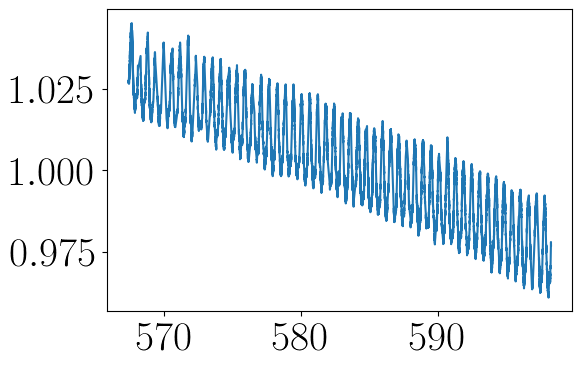

In [57]:
#month is the times of each month w/o flares
month1 = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[1].time)) & 
                 (gj1243lc.time[no_flares] <= np.max(gj1243_collection[1].time)) & 
                 (FlagCuts(gj1243lc.quality[no_flares]) < 1))[0]
y = medflux[month1]
t = gj1243lc.time[no_flares][month1]
yerr = 1+((gj1243lc.flux_err[no_flares][month1] - np.nanmedian(gj1243lc.flux[no_flares][month1]))/(np.nanmedian(gj1243lc.flux[no_flares][month1])))

plt.plot(t,y)

In [25]:
acf = xo.estimators.autocorr_estimator(t, y, yerr)

In [26]:
acf

{'autocorr': (array([0.00000000e+00, 3.40450115e-04, 6.80900230e-04, ...,
         3.09149131e+01, 3.09152536e+01, 3.09155940e+01]),
  array([ 9.99744335e-01,  9.99730327e-01,  9.99703374e-01, ...,
         -9.04442361e-05, -8.25427084e-05, -7.84698974e-05])),
 'peaks': [{'period': 0.5906809493353649, 'period_uncert': nan}]}

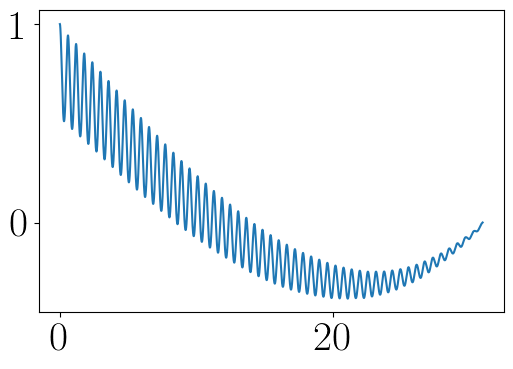

In [29]:
plt.plot(*acf['autocorr']);

In [58]:
actual_period = 0.592 # previously measured by Jim using lomb-scargle 

In [61]:
#based on the stellar variability example in exoplanet code
import theano.tensor as tt
with pm.Model() as model:

    #mean flux
    mean_flux = pm.Normal("mean_flux", mu=0.0, sigma=10.0)
    #sigma = pm.HalfNormal("sigma", sigma=np.mean(yerr))

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)
    
    #Rotation Kernel Parameters
    amp = pm.Lognormal("amp", mu=np.log(np.var(y)), sigma=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(actual_period), sigma=0.1)
    Q0 = pm.Lognormal("Q0", mu=0.0, sigma=10.0)
    deltaQ = pm.Lognormal("deltaQ", mu=0.0, sigma=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1)

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    #Setting up the GP
    
    kernel = xo.gp.terms.RotationTerm(amp=amp, period=period, Q0=Q0, deltaQ=deltaQ, mix=mix)
    gp = xo.gp.GP(kernel, t, diag=yerr ** 2 + tt.exp(logs2), mean=mean_flux)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean_flux))

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

    gp.marginal("obs", observed=y)

    print(model.check_test_point())

optimizing logp for variables: [mix, deltaQ, Q0, ligperiod, amp, logs2, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: 64277.34312148606 -> 131756.75170523694


mean_flux                  -3.22
logs2                      -1.61
amp_log__                  -2.53
ligperiod_interval__     -306.22
Q0_log__                   -3.22
deltaQ_log__               -3.22
mix_interval__             -1.39
obs                     64598.76
Name: Log-probability of test_point, dtype: float64


In [62]:
map_soln

{'mean_flux': array(0.50152413),
 'logs2': array(-15.49941234),
 'amp_log__': array(-8.13099912),
 'ligperiod_interval__': array(-4.37692156),
 'Q0_log__': array(-8.16600483),
 'deltaQ_log__': array(-0.6198087),
 'mix_interval__': array(-8.61600598),
 'amp': array(0.00029427),
 'ligperiod': array(0.0485407),
 'Q0': array(0.00028415),
 'deltaQ': array(0.53804736),
 'mix': array(0.00018115),
 'period': array(1.0497381),
 'pred': array([ 0.02424897,  0.02424183,  0.02423233, ..., -0.02537274,
        -0.0252723 , -0.025166  ])}

In [70]:
with model:

    soln = xo.optimize(vars=[mean_flux, logs2])
    soln = xo.optimize(soln)

optimizing logp for variables: [logs2, mean_flux]


message: Optimization terminated successfully.
logp: 128876.10068333293 -> 214937.56077048808
optimizing logp for variables: [mix, deltaQ, Q0, ligperiod, amp, logs2, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: 214937.56077048808 -> nan


In [71]:
with model:

    pred = xo.eval_in_model(gp.predict(), soln)

<ErrorbarContainer object of 3 artists>

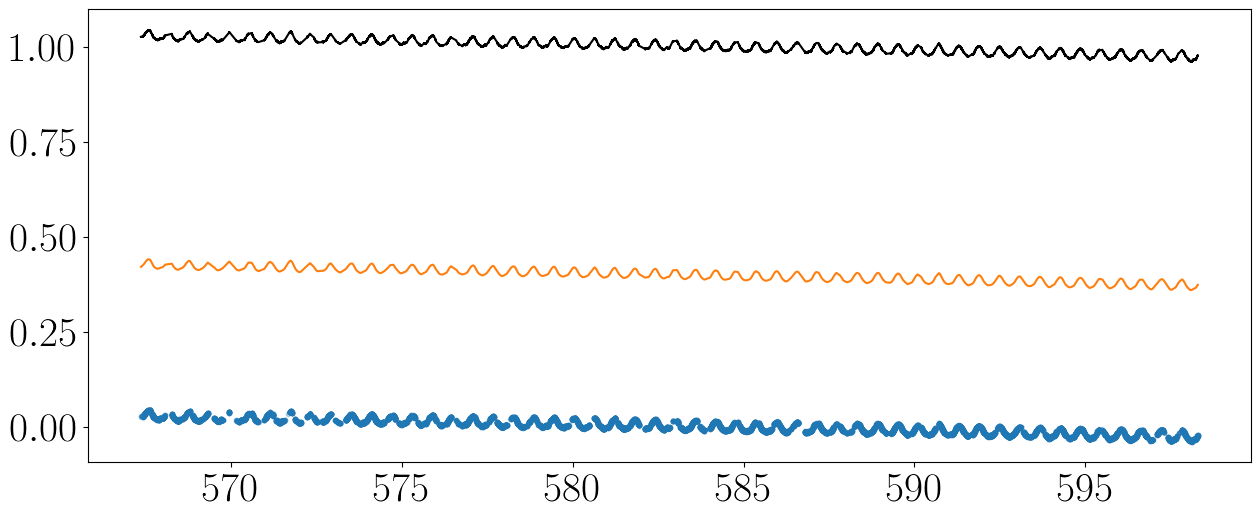

In [79]:
plt.figure(figsize=(15, 6))
plt.plot(t, y, "k")
plt.plot(t, pred, "C1")
plt.errorbar(t,y-1, yerr=yerr, linestyle='none', marker='.', alpha=0.3)
#plt.xlim(570,575)
#plt.ylim(0,0.05)

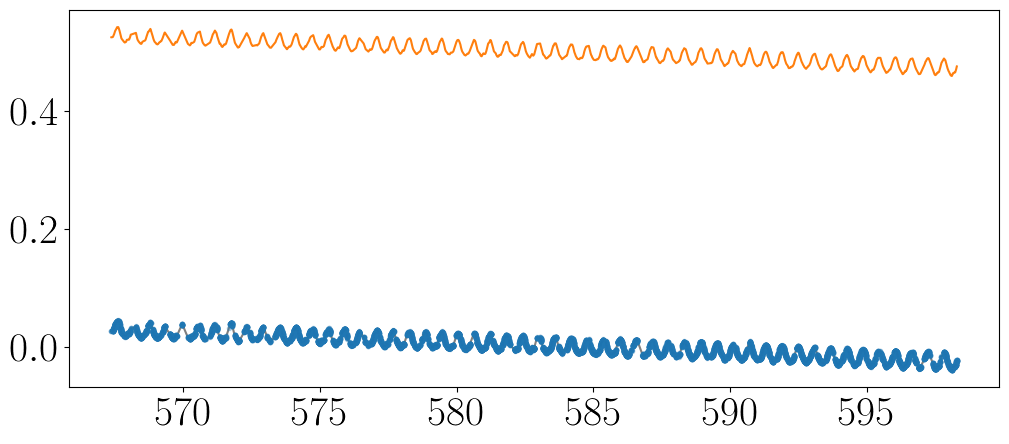

In [67]:

plt.figure(figsize=(12,5))
plt.errorbar(t,y-1, yerr=yerr, linestyle='none', marker='.', alpha=0.3)
plt.plot(t,y-1, c='k', alpha=0.5)

plt.plot(t,map_soln['pred']+map_soln['mean_flux'],color='C1', zorder=10)
#plt.xlim(551,552)
#plt.ylim(.99,1.02)

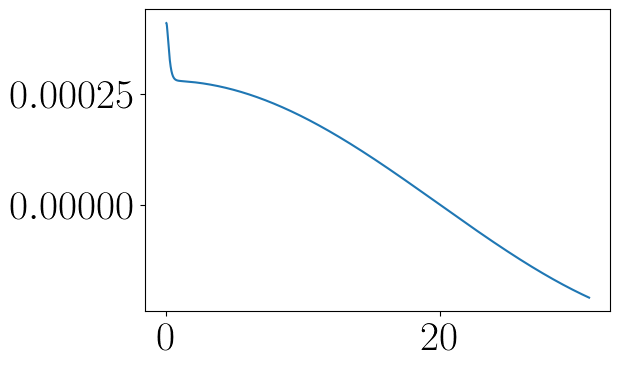

In [39]:
with model:

    plt.plot(acf["autocorr"][0], xo.eval_in_model(kernel.value(acf["autocorr"][0]), soln))

In [80]:
#this takes time to run
with model:

    trace = pm.sample(step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, deltaQ, Q0, ligperiod, amp, logs2, mean_flux]
INFO:pymc3:NUTS: [mix, deltaQ, Q0, ligperiod, amp, logs2, mean_flux]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1759 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1759 seconds.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [81]:
with model:
    summary = pm.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_flux,0.603,0.018,0.568,0.634,0.001,0.000,818.0,818.0,831.0,1129.0,1.0
logs2,-15.421,0.010,-15.440,-15.403,0.000,0.000,593.0,593.0,595.0,793.0,1.0
amp,0.055,0.011,0.037,0.076,0.000,0.000,777.0,722.0,844.0,819.0,1.0
ligperiod,1.496,0.040,1.430,1.576,0.002,0.001,668.0,668.0,665.0,927.0,1.0
Q0,0.893,0.225,0.549,1.309,0.008,0.006,764.0,739.0,755.0,958.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
pred[21972],-0.228,0.035,-0.291,-0.158,0.001,0.001,818.0,818.0,831.0,1129.0,1.0
pred[21973],-0.228,0.035,-0.291,-0.158,0.001,0.001,818.0,818.0,831.0,1129.0,1.0
pred[21974],-0.228,0.035,-0.290,-0.158,0.001,0.001,818.0,818.0,831.0,1129.0,1.0
pred[21975],-0.228,0.035,-0.290,-0.158,0.001,0.001,818.0,818.0,831.0,1129.0,1.0


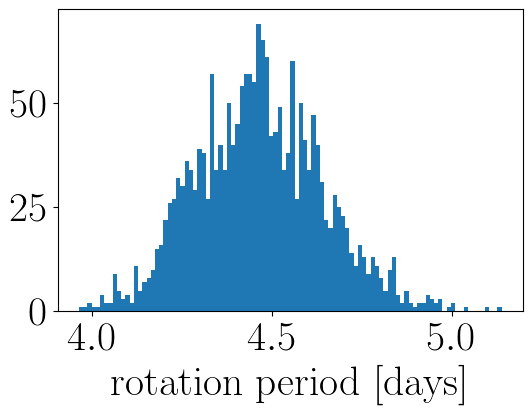

In [83]:
plt.hist(trace["period"], 100)
plt.xlabel("rotation period [days]");
#plt.xlim(40,1500)

In [84]:
np.mean(trace["period"]), np.std(trace["period"])

(4.4664058983387624, 0.17698567105533555)

In [85]:
import corner

corner.corner(pm.trace_to_dataframe(trace));

AssertionError: I don't believe that you want more dimensions than samples!

In [ ]:
#mapping gp fit to original time with flares
month1_flares = np.where((gj1243lc.time >= np.min(gj1243_collection[1].time)) & 
                 (gj1243lc.time <= np.max(gj1243_collection[1].time)) & 
                 (FlagCuts(gj1243lc.quality) < 1))[0]

new_x = gj1243lc.time[month1_flares]

print(t.shape,new_x.shape)

In [ ]:
# simialr to SHOTerm in celerite will take time to run
with model:
    #mu1, var1 = xo.eval_in_model(gp.predict(xnew, return_var=True), map_soln)
    mu1 = xo.eval_in_model(gp.predict(xnew, return_var=False), map_soln)

In [ ]:

plt.figure(figsize=(12,5))
plt.errorbar(t,y, yerr=yerr, linestyle='none', marker='.', alpha=0.3)
plt.plot(t, y, "k")
plt.plot(t, pred, "C1")
#plt.errorbar(t,y-1, yerr=yerr, linestyle='none', marker='.', alpha=0.3)


#plt.xlim(570,575)
#pmean_fluxlim(0,0.05)

plt.plot(xnew, mu1+map_soln['mean_flux'], c='C1')
plt.fill_between(xnew, mu1-np.sqrt(var1)+map_soln['mean_flux'], 
                 mu1+np.sqrt(var1)+map_soln['mean_flux'], 
                 alpha=0.4, color='C1')